In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import spiceypy as spice

In [10]:
spice.tkvrsn("TOOLKIT")

'CSPICE_N0066'

In [11]:
def graph_kernel( kernel, start_time, end_time, step = 2000 ):
    kernels = ['aig_ch1_sclk_complete_biased_m1p816.tsc', 'naif0012.tls']
    kernels.append(kernel + '.bc')
    kernels.append(kernel + '.bsp')
    
    spice.furnsh(kernels)
    
    # get et values one and two, we could vectorize str2et
    etOne = spice.str2et(start_time)
    etTwo = spice.str2et(end_time)
    
    times = [x*(etTwo-etOne)/step + etOne for x in range(step)]
    positions, lightTimes = spice.spkpos('MOON', times, 'J2000', 'NONE', 'CH1')
    positions = np.asarray(positions).T # positions is a list, make it an ndarray for easier indexing
    fig = plt.figure(figsize=(10, 10))
    ax  = fig.add_subplot(111, projection='3d')
    ax.plot(positions[0], positions[1], positions[2])
    plt.title('{} from {} to {}'.format(kernel, start_time, end_time))
    plt.show()
    spice.kclear()

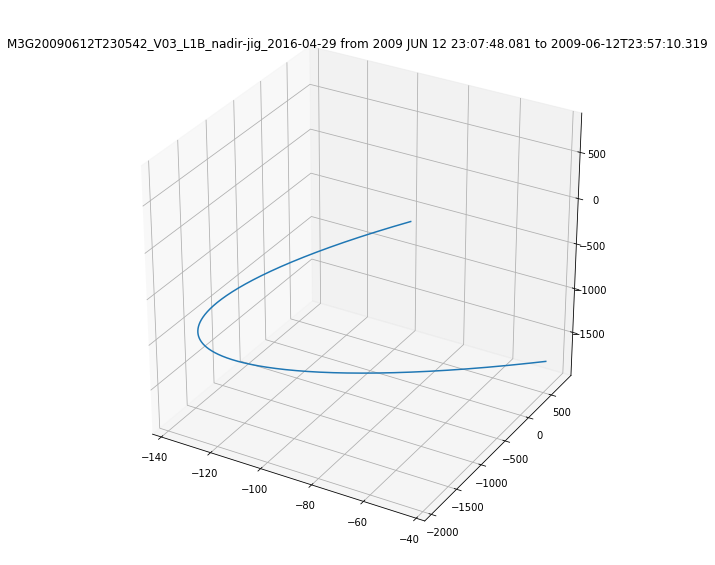

In [12]:
graph_kernel('M3G20090612T230542_V03_L1B_nadir-jig_2016-04-29', '2009 JUN 12 23:07:48.081', '2009-06-12T23:57:10.319')

In [36]:
def graph_deltas( kernel1, kernel2 ,start_time, end_time, step = 2000 ):
    kernels = ['aig_ch1_sclk_complete_biased_m1p816.tsc', 'naif0012.tls']
    kernels.append(kernel1 + '.bc')
    kernels.append(kernel1 + '.bsp')
    
    spice.furnsh(kernels)
    
    # get et values one and two, we could vectorize str2et
    etOne = spice.str2et(start_time)
    etTwo = spice.str2et(end_time)
    
    times = [x*(etTwo-etOne)/step + etOne for x in range(step)]
    positions1, lightTimes1 = spice.spkpos('MOON', times, 'J2000', 'NONE', 'CH1')
    positions1 = np.asarray(positions1).T # positions is a list, make it an ndarray for easier indexing
    spice.kclear()
    
    kernels = ['aig_ch1_sclk_complete_biased_m1p816.tsc', 'naif0012.tls']
    kernels.append(kernel2 + '.bc')
    kernels.append(kernel2 + '.bsp')
    
    spice.furnsh(kernels)
    
    # get et values one and two, we could vectorize str2et
    etOne = spice.str2et(start_time)
    etTwo = spice.str2et(end_time)
    
    times = [x*(etTwo-etOne)/step + etOne for x in range(step)]
    positions2, lightTimes2 = spice.spkpos('MOON', times, 'J2000', 'NONE', 'CH1')
    positions2 = np.asarray(positions2).T # positions is a list, make it an ndarray for easier indexing
    spice.kclear()

    positions = [[], [], []]
    for i in range(3):
        positions[i] = np.subtract(positions1[i], positions2[i])
        
    
    fig = plt.figure(figsize=(10, 10))
    ax  = fig.add_subplot(111, projection='3d')
    ax.plot(positions[0], positions[1], positions[2])
    plt.title('Delta of {} and {} from {} to {}'.format(kernel1, kernel2, start_time, end_time))
    plt.show()

# Graphing Function Above Works With nadir and basematchgrnd files

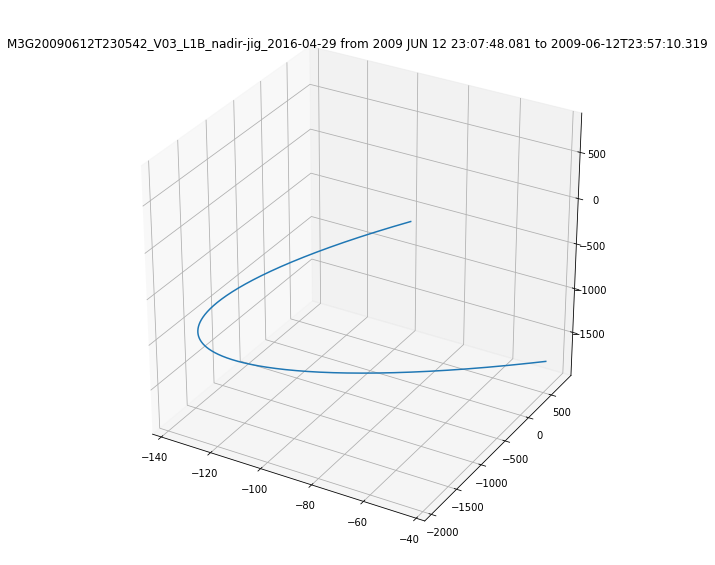

In [37]:
# nadir
graph_kernel('M3G20090612T230542_V03_L1B_nadir-jig_2016-04-29', '2009 JUN 12 23:07:48.081', '2009-06-12T23:57:10.319')

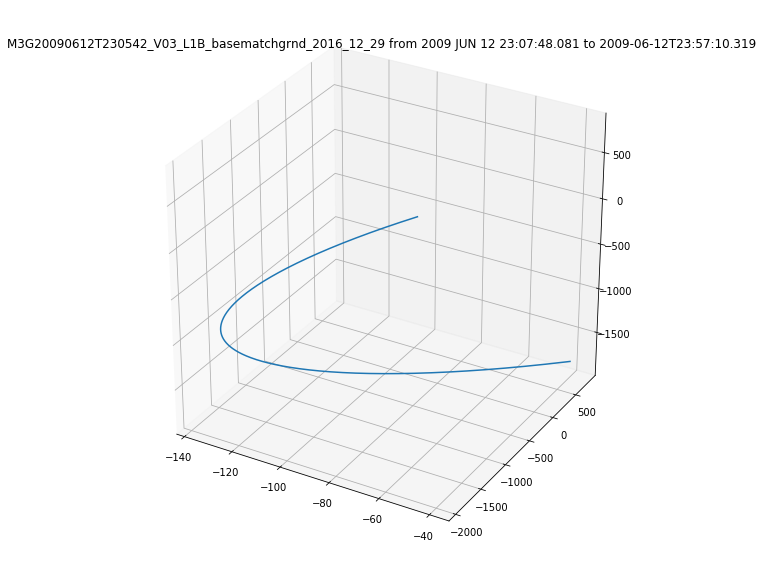

In [38]:
# basematchgrnd
graph_kernel('M3G20090612T230542_V03_L1B_basematchgrnd_2016_12_29', '2009 JUN 12 23:07:48.081', '2009-06-12T23:57:10.319')

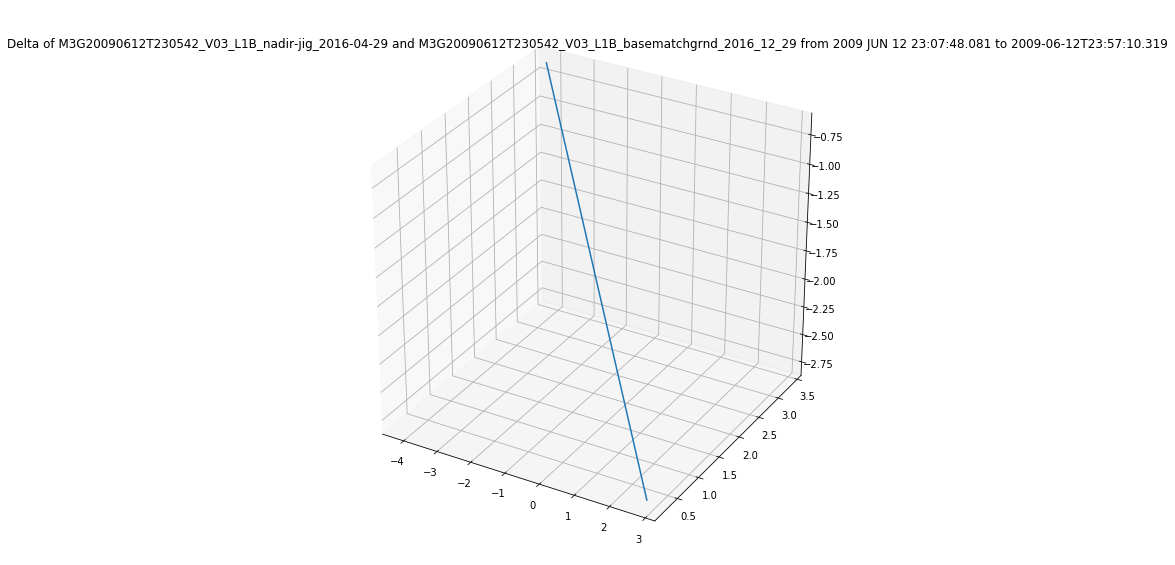

In [39]:
# delta of pre and post above
graph_deltas( 'M3G20090612T230542_V03_L1B_nadir-jig_2016-04-29', 'M3G20090612T230542_V03_L1B_basematchgrnd_2016_12_29', '2009 JUN 12 23:07:48.081', '2009-06-12T23:57:10.319' )

# Orientation

In [41]:
# pxform should get camera matrix and then multiply by position vectors to get orientation
help(spice.pxform)

Help on function pxform in module spiceypy.spiceypy:

pxform(fromstr, tostr, et)
    Return the matrix that transforms position vectors from one
    specified frame to another at a specified epoch.
    
    http://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/pxform_c.html
    
    :param fromstr: Name of the frame to transform from.
    :type fromstr: str
    :param tostr: Name of the frame to transform to.
    :type tostr: str
    :param et: Epoch of the rotation matrix.
    :type et: float
    :return: A rotation matrix.
    :rtype: 3x3 Element Array of floats



In [42]:
# this would be how we would get a camera matrix at each time to then multiply by after
kernels = ['M3G20090612T230542_V03_L1B_basematchgrnd_2016_12_29.bsp', 'M3G20090612T230542_V03_L1B_basematchgrnd_2016_12_29.bc', 'aig_ch1_sclk_complete_biased_m1p816.tsc', 'naif0012.tls']
spice.furnsh(kernels)
step = 2000

utc = ['2009 JUN 12 23:07:48.081', '2009-06-12T23:57:10.319']

etOne = spice.str2et(utc[0])
etTwo = spice.str2et(utc[1])

times = [x*(etTwo-etOne)/step + etOne for x in range(step)]

orientations = []
for time in times:
    orientations.append( spice.pxform('J2000', 'CH1', time) )
# it doesnt work because the reference frame for the chayaandra-1 is not CH1, why would it be 

SpiceyError: 
================================================================================

Toolkit version: N0066

SPICE(UNKNOWNFRAME) --

The frame CH1 was not recognized as a known reference frame.

pxform_c --> PXFORM

================================================================================

In [45]:
help(spice.cidfrm)
# this function can be used to get reference frame for a target, spacecraft, or instrument

Help on function cidfrm in module spiceypy.spiceypy:

cidfrm(cent, lenout=256)
    Retrieve frame ID code and name to associate with a frame center.
    
    http://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/cidfrm_c.html
    
    :param cent: An object to associate a frame with.
    :type cent: int
    :param lenout: Available space in output string frname.
    :type lenout: int
    :return:
            frame ID code,
            name to associate with a frame center.
    :rtype: tuple



In [46]:
spice.cidfrm(301)
# example of it working with the ID for the target MOON

(10020, 'IAU_MOON')

In [47]:
spice.cidfrm(-86)
# it doesnt work for the ID of the spacecraft because it doesnt have a reference frame

SpiceyError: Spice returns not found for function: cidfrm